# Data

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
def load_ephemeris(filename):
    pos = []
    vel = []
    with open(filename, 'r') as f:
        in_data = False
        for line in f:
            if line.strip() == "$$SOE":
                in_data = True
                continue
            if line.strip() == "$$EOE":
                break
            if in_data:
                parts = line.split(',')
                if len(parts) < 8:
                    continue
                try:
                    x, y, z = map(float, parts[2:5])
                    vx, vy, vz = map(float, parts[5:8])
                except ValueError:
                    continue
                pos.append([x, y, z])
                vel.append([vx, vy, vz])
    return np.array(pos), np.array(vel)


In [ ]:
sun_file = 'data/sun.txt'
earth_file = 'data/earth.txt'
asteroid_file = 'data/2024YR4.txt'

# load sun, earth, and asteroid ephemeris data
sun_position_ssb,   sun_velocity_ssb   = load_ephemeris(sun_file)
earth_position_ssb, earth_velocity_ssb = load_ephemeris(earth_file)
asteroid_position_ssb,   asteroid_velocity_ssb   = load_ephemeris(asteroid_file)

# calculate relative positions and velocities
earth_position_relative = earth_position_ssb - sun_position_ssb
asteroid_position_relative   = asteroid_position_ssb   - sun_position_ssb
earth_velocity_relative = earth_velocity_ssb - sun_velocity_ssb
asteroid_velocity_relative   = asteroid_velocity_ssb   - sun_velocity_ssb

RMSE between Simulation and NASA Data: 3127499.43 km


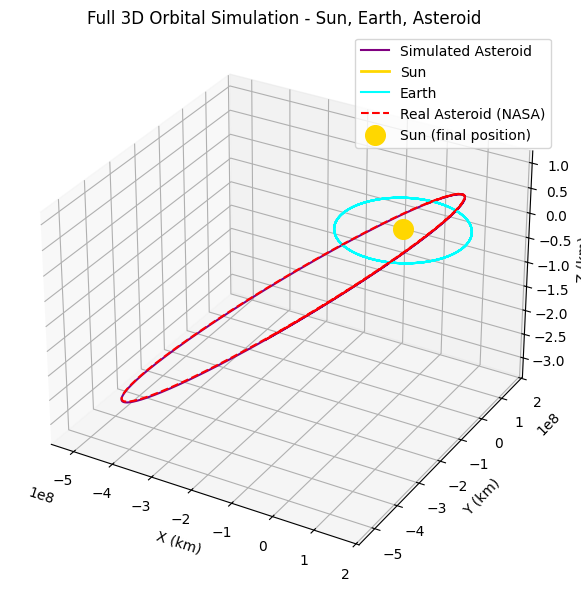

In [ ]:
def run_three_body_simulation(asteroid_position_ssb, asteroid_velocity_ssb, earth_position_ssb, earth_velocity_ssb, sun_position_ssb, sun_velocity_ssb, time_step=60 * 60 * 24, max_time=157680000, gravitational_constant=6.67430e-20, asteroid_mass=1e14, sun_mass=1.9885e30, earth_mass=5.9722e24, distance_multiplier=1.0):

    # sim params
    time = 0.0
    real_x, real_y, real_z = asteroid_position_ssb[:,0], asteroid_position_ssb[:,1], asteroid_position_ssb[:,2]

    time = 0.0
    real_x, real_y, real_z = asteroid_position_ssb[:,0], asteroid_position_ssb[:,1], asteroid_position_ssb[:,2]


    # Calculate relative positions and velocities
    earth_position_relative = earth_position_ssb - sun_position_ssb
    asteroid_position_relative = asteroid_position_ssb - sun_position_ssb
    earth_velocity_relative = earth_velocity_ssb - sun_velocity_ssb
    asteroid_velocity_relative = asteroid_velocity_ssb - sun_velocity_ssb

    # Initial positions
    asteroid_x, asteroid_y, asteroid_z = asteroid_position_relative[0]
    sun_x, sun_y, sun_z = 0.0, 0.0, 0.0
    earth_x, earth_y, earth_z = earth_position_relative[0]

    # Initial velocities
    asteroid_vx, asteroid_vy, asteroid_vz = asteroid_velocity_relative[0]
    sun_vx, sun_vy, sun_vz = 0.0, 0.0, 0.0
    earth_vx, earth_vy, earth_vz = earth_velocity_relative[0]

    # Initialize trajectory lists
    times = [time]
    asteroid_trajectory = {'x': [asteroid_x], 'y': [asteroid_y], 'z': [asteroid_z]}
    sun_trajectory = {'x': [sun_x], 'y': [sun_y], 'z': [sun_z]}
    earth_trajectory = {'x': [earth_x], 'y': [earth_y], 'z': [earth_z]}

    real_trajectory = {'x': [], 'y': [], 'z': []}
    errors = []

    while time < max_time:
        # Calculate accelerations for asteroid
        dx_asteroid_sun = sun_x - asteroid_x
        dy_asteroid_sun = sun_y - asteroid_y
        dz_asteroid_sun = sun_z - asteroid_z
        r_asteroid_sun = np.sqrt(dx_asteroid_sun**2 + dy_asteroid_sun**2 + dz_asteroid_sun**2) *distance_multiplier

        dx_asteroid_earth = earth_x - asteroid_x
        dy_asteroid_earth = earth_y - asteroid_y
        dz_asteroid_earth = earth_z - asteroid_z
        r_asteroid_earth = np.sqrt(dx_asteroid_earth**2 + dy_asteroid_earth**2 + dz_asteroid_earth**2) *distance_multiplier

        # Asteroid acceleration components
        asteroid_ax_sun = gravitational_constant * sun_mass * dx_asteroid_sun / r_asteroid_sun**3
        asteroid_ay_sun = gravitational_constant * sun_mass * dy_asteroid_sun / r_asteroid_sun**3
        asteroid_az_sun = gravitational_constant * sun_mass * dz_asteroid_sun / r_asteroid_sun**3

        asteroid_ax_earth = gravitational_constant * earth_mass * dx_asteroid_earth / r_asteroid_earth**3
        asteroid_ay_earth = gravitational_constant * earth_mass * dy_asteroid_earth / r_asteroid_earth**3
        asteroid_az_earth = gravitational_constant * earth_mass * dz_asteroid_earth / r_asteroid_earth**3

        asteroid_ax = asteroid_ax_sun + asteroid_ax_earth
        asteroid_ay = asteroid_ay_sun + asteroid_ay_earth
        asteroid_az = asteroid_az_sun + asteroid_az_earth

        # Calculate accelerations for sun
        dx_sun_asteroid = asteroid_x - sun_x
        dy_sun_asteroid = asteroid_y - sun_y
        dz_sun_asteroid = asteroid_z - sun_z
        r_sun_asteroid = np.sqrt(dx_sun_asteroid**2 + dy_sun_asteroid**2 + dz_sun_asteroid**2) *distance_multiplier

        dx_sun_earth = earth_x - sun_x
        dy_sun_earth = earth_y - sun_y
        dz_sun_earth = earth_z - sun_z
        r_sun_earth = np.sqrt(dx_sun_earth**2 + dy_sun_earth**2 + dz_sun_earth**2) *distance_multiplier

        # Sun acceleration components
        sun_ax_asteroid = gravitational_constant * asteroid_mass * dx_sun_asteroid / r_sun_asteroid**3
        sun_ay_asteroid = gravitational_constant * asteroid_mass * dy_sun_asteroid / r_sun_asteroid**3
        sun_az_asteroid = gravitational_constant * asteroid_mass * dz_sun_asteroid / r_sun_asteroid**3

        sun_ax_earth = gravitational_constant * earth_mass * dx_sun_earth / r_sun_earth**3
        sun_ay_earth = gravitational_constant * earth_mass * dy_sun_earth / r_sun_earth**3
        sun_az_earth = gravitational_constant * earth_mass * dz_sun_earth / r_sun_earth**3

        sun_ax = sun_ax_asteroid + sun_ax_earth
        sun_ay = sun_ay_asteroid + sun_ay_earth
        sun_az = sun_az_asteroid + sun_az_earth

        # Calculate accelerations for earth
        dx_earth_asteroid = asteroid_x - earth_x
        dy_earth_asteroid = asteroid_y - earth_y
        dz_earth_asteroid = asteroid_z - earth_z
        r_earth_asteroid = np.sqrt(dx_earth_asteroid**2 + dy_earth_asteroid**2 + dz_earth_asteroid**2) *distance_multiplier

        dx_earth_sun = sun_x - earth_x
        dy_earth_sun = sun_y - earth_y
        dz_earth_sun = sun_z - earth_z
        r_earth_sun = np.sqrt(dx_earth_sun**2 + dy_earth_sun**2 + dz_earth_sun**2) *distance_multiplier

        # Earth acceleration components
        earth_ax_asteroid = gravitational_constant * asteroid_mass * dx_earth_asteroid / r_earth_asteroid**3
        earth_ay_asteroid = gravitational_constant * asteroid_mass * dy_earth_asteroid / r_earth_asteroid**3
        earth_az_asteroid = gravitational_constant * asteroid_mass * dz_earth_asteroid / r_earth_asteroid**3

        earth_ax_sun = gravitational_constant * sun_mass * dx_earth_sun / r_earth_sun**3
        earth_ay_sun = gravitational_constant * sun_mass * dy_earth_sun / r_earth_sun**3
        earth_az_sun = gravitational_constant * sun_mass * dz_earth_sun / r_earth_sun**3

        earth_ax = earth_ax_asteroid + earth_ax_sun
        earth_ay = earth_ay_asteroid + earth_ay_sun
        earth_az = earth_az_asteroid + earth_az_sun

        # Update velocities
        asteroid_vx += asteroid_ax * time_step
        asteroid_vy += asteroid_ay * time_step
        asteroid_vz += asteroid_az * time_step

        sun_vx += sun_ax * time_step
        sun_vy += sun_ay * time_step
        sun_vz += sun_az * time_step

        earth_vx += earth_ax * time_step
        earth_vy += earth_ay * time_step
        earth_vz += earth_az * time_step

        # Update positions
        asteroid_x += asteroid_vx * time_step
        asteroid_y += asteroid_vy * time_step
        asteroid_z += asteroid_vz * time_step

        sun_x += sun_vx * time_step
        sun_y += sun_vy * time_step
        sun_z += sun_vz * time_step

        earth_x += earth_vx * time_step
        earth_y += earth_vy * time_step
        earth_z += earth_vz * time_step

        # Record real trajectory and calculate errors
        index = int(time // time_step)
        if index < len(real_x):
            real_trajectory['x'].append(real_x[index])
            real_trajectory['y'].append(real_y[index])
            real_trajectory['z'].append(real_z[index])

            error_x = asteroid_x - real_x[index]
            error_y = asteroid_y - real_y[index]
            error_z = asteroid_z - real_z[index]
            error = np.sqrt(error_x**2 + error_y**2 + error_z**2)
            errors.append(error)

        # Record trajectories
        times.append(time)
        asteroid_trajectory['x'].append(asteroid_x)
        asteroid_trajectory['y'].append(asteroid_y)
        asteroid_trajectory['z'].append(asteroid_z)
        sun_trajectory['x'].append(sun_x)
        sun_trajectory['y'].append(sun_y)
        sun_trajectory['z'].append(sun_z)
        earth_trajectory['x'].append(earth_x)
        earth_trajectory['y'].append(earth_y)
        earth_trajectory['z'].append(earth_z)

        time += time_step

    return {
        'times': times,
        'asteroid_trajectory': asteroid_trajectory,
        'sun_trajectory': sun_trajectory,
        'earth_trajectory': earth_trajectory,
        'real_trajectory': real_trajectory,
        'errors': errors
    }

# --- Plot the full 3D Trajectories ---
def plot_simulation_results(simulation_results):
    """
    Plot the simulation results including trajectories of all bodies and error analysis.

    Args:
        simulation_results: Dictionary containing simulation results from run_three_body_simulation
    """
    # Calculate RMSE
    errors = np.array(simulation_results['errors'])
    rmse = np.sqrt(np.mean(errors**2))
    print(f"RMSE between Simulation and NASA Data: {rmse:.2f} km")

    # Create 3D plot
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot trajectories with new colors
    ax.plot(simulation_results['asteroid_trajectory']['x'],
            simulation_results['asteroid_trajectory']['y'],
            simulation_results['asteroid_trajectory']['z'],
            label='Simulated Asteroid', color='purple', linewidth=1.5)

    ax.plot(simulation_results['sun_trajectory']['x'],
            simulation_results['sun_trajectory']['y'],
            simulation_results['sun_trajectory']['z'],
            label='Sun', color='gold', linewidth=2)

    ax.plot(simulation_results['earth_trajectory']['x'],
            simulation_results['earth_trajectory']['y'],
            simulation_results['earth_trajectory']['z'],
            label='Earth', color='cyan', linewidth=1.5)

    # Plot real asteroid trajectory
    ax.plot(simulation_results['real_trajectory']['x'],
            simulation_results['real_trajectory']['y'],
            simulation_results['real_trajectory']['z'],
            label='Real Asteroid (NASA)', linestyle='--', color='red', linewidth=1.5)

    # Add a larger point for the sun at its final position
    final_sun_x = simulation_results['sun_trajectory']['x'][-1]
    final_sun_y = simulation_results['sun_trajectory']['y'][-1]
    final_sun_z = simulation_results['sun_trajectory']['z'][-1]
    ax.scatter(final_sun_x, final_sun_y, final_sun_z, color='gold', s=200, label='Sun (final position)')

    # Set labels and title
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    ax.set_zlabel('Z (km)')
    ax.set_title('Full 3D Orbital Simulation - Sun, Earth, Asteroid')
    ax.legend()
    plt.tight_layout()
    plt.show()



simulation_results = run_three_body_simulation(
    asteroid_position_ssb=asteroid_position_ssb,
    asteroid_velocity_ssb=asteroid_velocity_ssb,
    earth_position_ssb=earth_position_ssb,
    earth_velocity_ssb=earth_velocity_ssb,
    sun_position_ssb=sun_position_ssb,
    sun_velocity_ssb=sun_velocity_ssb
)

plot_simulation_results(simulation_results)

### Change Asteriod Mass

RMSE between Simulation and NASA Data: 6203294.41 km


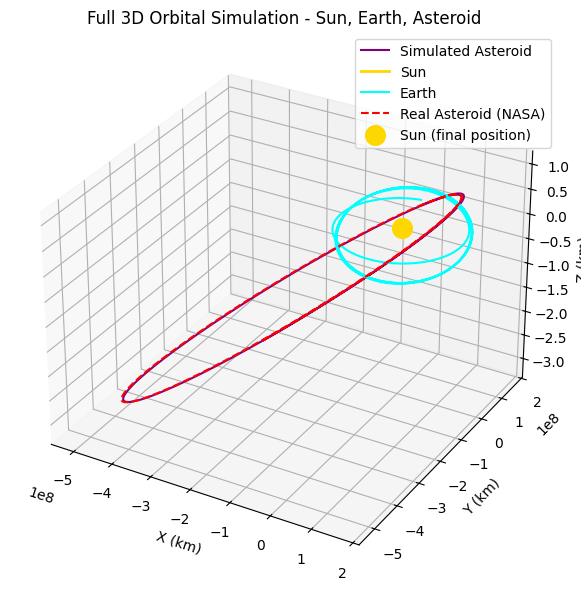

In [5]:
simulation_results = run_three_body_simulation(
    asteroid_position_ssb=asteroid_position_ssb,
    asteroid_velocity_ssb=asteroid_velocity_ssb,
    earth_position_ssb=earth_position_ssb,
    earth_velocity_ssb=earth_velocity_ssb,
    sun_position_ssb=sun_position_ssb,
    sun_velocity_ssb=sun_velocity_ssb,
    asteroid_mass=4.5e27
)

plot_simulation_results(simulation_results)

### Changing Sun Mass

RMSE between Simulation and NASA Data: 370311181.39 km


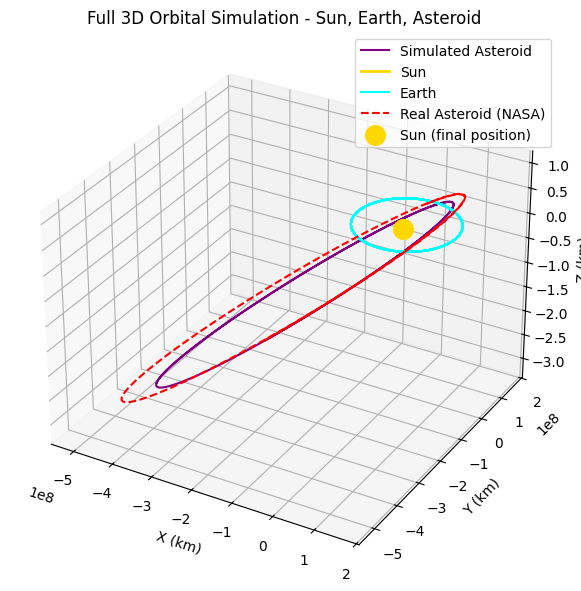

In [6]:
simulation_results = run_three_body_simulation(
    asteroid_position_ssb=asteroid_position_ssb,
    asteroid_velocity_ssb=asteroid_velocity_ssb,
    earth_position_ssb=earth_position_ssb,
    earth_velocity_ssb=earth_velocity_ssb,
    sun_position_ssb=sun_position_ssb,
    sun_velocity_ssb=sun_velocity_ssb,
    sun_mass=2.5e30
)

plot_simulation_results(simulation_results)

RMSE between Simulation and NASA Data: 669404630.78 km


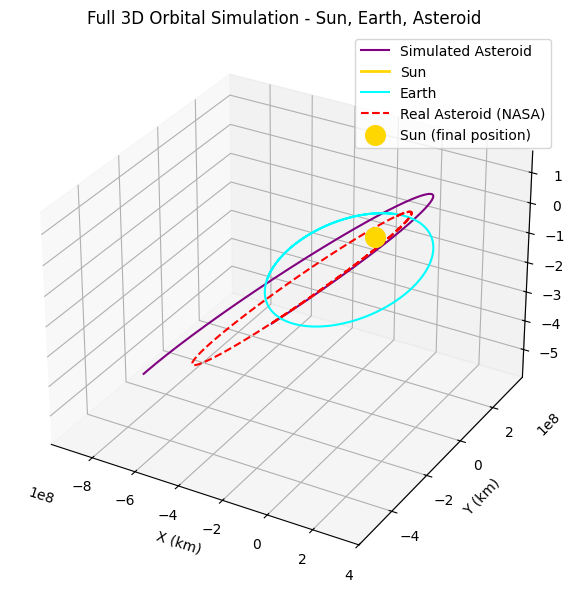

In [18]:
simulation_results = run_three_body_simulation(
    asteroid_position_ssb=asteroid_position_ssb,
    asteroid_velocity_ssb=asteroid_velocity_ssb,
    earth_position_ssb=earth_position_ssb,
    earth_velocity_ssb=earth_velocity_ssb,
    sun_position_ssb=sun_position_ssb,
    sun_velocity_ssb=sun_velocity_ssb,
    sun_mass=1.3e30
)

plot_simulation_results(simulation_results)

### Change the Distance

RMSE between Simulation and NASA Data: 485497330.70 km


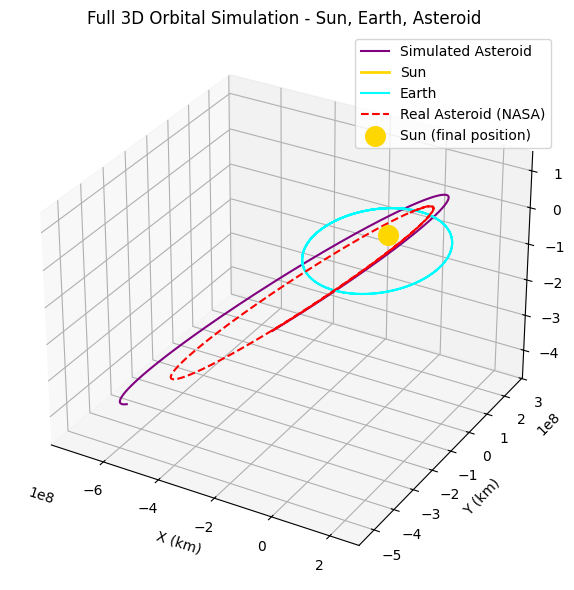

In [7]:
simulation_results = run_three_body_simulation(
    asteroid_position_ssb=asteroid_position_ssb,
    asteroid_velocity_ssb=asteroid_velocity_ssb,
    earth_position_ssb=earth_position_ssb,
    earth_velocity_ssb=earth_velocity_ssb,
    sun_position_ssb=sun_position_ssb,
    sun_velocity_ssb=sun_velocity_ssb,
    distance_multiplier= 1.1

)

plot_simulation_results(simulation_results)

# Optimizing G

## GA

Running Genetic Algorithm: 100%|██████████| 20/20 [00:55<00:00,  2.75s/it]

Best G: 8e-20, RMSE: 334875937.01709634


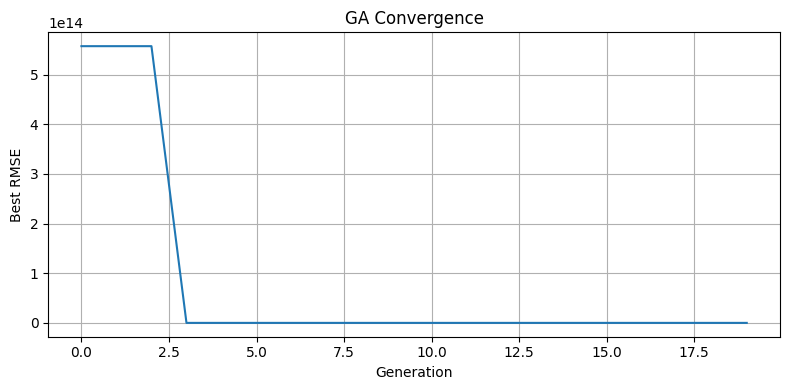

In [8]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
best_history=[]

best_gs=[]

# --- Fitness Function ---
def fitness(G):
    try:
        simulation_results = run_three_body_simulation(
    asteroid_position_ssb=asteroid_position_ssb,
    asteroid_velocity_ssb=asteroid_velocity_ssb,
    earth_position_ssb=earth_position_ssb,
    earth_velocity_ssb=earth_velocity_ssb,
    sun_position_ssb=sun_position_ssb,
    sun_velocity_ssb=sun_velocity_ssb,
    gravitational_constant=G)

        errors = np.array(simulation_results["errors"])
        if len(errors) == 0:
            return np.inf
        rmse = np.sqrt(np.mean(errors**2))
        return -rmse
    except:
        return np.inf

# --- GA Parameters ---
pop_size = 100
n_gen = 20
crossover_p = 0.8
mutate_p = 0.2
G_bounds = (5.0e-10, 8.0e-20)
elite_count = 15

# Initialize Population
pop = np.random.uniform(low=G_bounds[0], high=G_bounds[1], size=pop_size)

# GA Loop with tqdm
for gen in tqdm(range(n_gen), desc="Running Genetic Algorithm"):
    fitness_vals = np.array([fitness(g) for g in pop])
    best_idx = np.argmax(fitness_vals)
    best_ind = pop[best_idx].copy()
    best_rmse = -fitness_vals[best_idx]
    best_history.append((best_rmse, best_ind))

    elite_indices = np.argsort(fitness_vals)[-elite_count:]
    elites = pop[elite_indices].copy()

    min_f = fitness_vals.min()
    weights = (fitness_vals - min_f + 1e-8) if min_f < 0 else fitness_vals
    probs = weights / weights.sum()

    parent_indices = np.random.choice(np.arange(pop_size), size=(pop_size - elite_count), replace=True, p=probs)
    selected = pop[parent_indices].copy()
    new_pop = np.concatenate([elites, selected])

    mutation_scale = np.clip((G_bounds[1] - G_bounds[0]) * max(0.05, 0.3 - 0.25 * gen / n_gen), 1e-22, None)


    if np.random.rand() < mutate_p:
        new_pop[gen] += np.random.normal(scale=mutation_scale)
        new_pop[gen] = np.clip(new_pop[gen], *G_bounds)

    pop = new_pop

# Final Results
best_rmse, best_ind = best_history[0]
best_G = best_ind
for rmse, ind in best_history[1:]:
    if rmse < best_rmse:
        best_rmse = rmse
        best_G = ind

print(f"Best G: {best_G}, RMSE: {best_rmse}")

best_rmses = []

best_gs.append(best_G)
best_rmses.append(best_rmse)

# Plot convergence
gens = np.arange(len(best_history))
rmses = [h[0] for h in best_history]
plt.figure(figsize=(8, 4))
plt.plot(gens, rmses)
plt.xlabel('Generation')
plt.ylabel('Best RMSE')
plt.title('GA Convergence')
plt.grid(True)
plt.tight_layout()
plt.show()

## SA

100%|██████████| 50/50 [00:01<00:00, 35.20it/s]


Best G: 6.6794e-20, RMSE: 2214064.794476


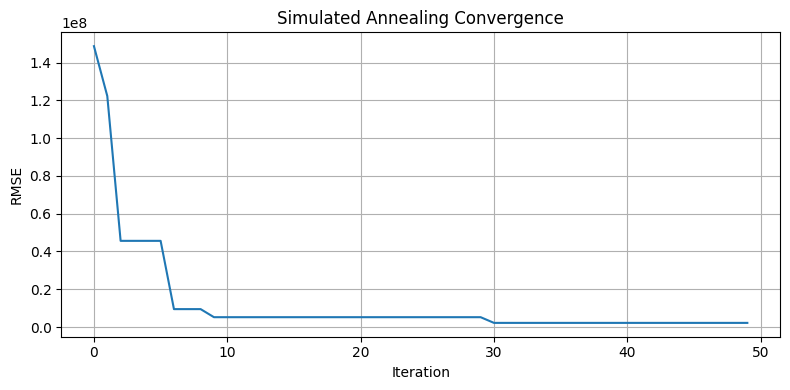

In [9]:
# --- Simulated Annealing Parameters ---
G_bounds = (5.67430e-20, 7.67430e-20)
n_iter = 50
T0 = 1.0
alpha = 0.995
noise_scale = (7.67430e-20-5.67430e-20) * 0.05

# --- Simulated Annealing Main Loop ---
current = np.random.uniform(low=G_bounds[0], high=G_bounds[1])
current_fitness = fitness(current)

best = current
best_fitness = current_fitness

rmse_history = []
T = T0

for i in tqdm(range(n_iter)):
    proposal = current + np.random.normal(scale=noise_scale)
    proposal = np.clip(proposal, *G_bounds)
    proposal_fitness = fitness(proposal)

    if proposal_fitness > current_fitness:
        current = proposal
        current_fitness = proposal_fitness
    else:
        accept_prob = np.exp((proposal_fitness - current_fitness) / T)
        if np.random.rand() < accept_prob:
            current = proposal
            current_fitness = proposal_fitness

    if current_fitness > best_fitness:
        best = current
        best_fitness = current_fitness

    rmse_history.append(-current_fitness)
    T *= alpha

# --- Results ---
best_G = best
best_rmse = -best_fitness
print(f"Best G: {best_G:.4e}, RMSE: {best_rmse:.6f}")

best_gs.append(best_G)
best_rmses.append(best_rmse)

# --- Convergence Plot ---
plt.figure(figsize=(8, 4))
plt.plot(rmse_history)
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Simulated Annealing Convergence')
plt.grid(True)
plt.tight_layout()
plt.show()


## GD

100%|██████████| 1000/1000 [01:22<00:00, 12.07it/s]


Best G: 7.6743e-20, RMSE: 289124095.38141096


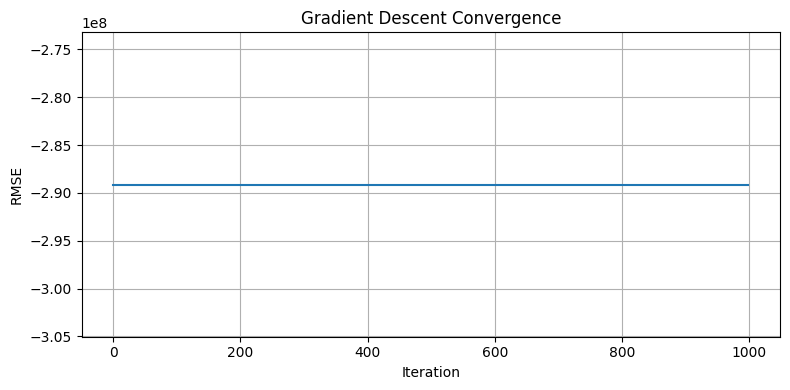

In [10]:
# Finite Difference Gradient Approximation
def compute_gradient(G, epsilon=1e-5):
    f1 = fitness(G + epsilon)
    f2 = fitness(G - epsilon)
    grad = (f1 - f2) / (2 * epsilon)
    return grad

# Gradient Descent Parameters
n_iter = 1000
learning_rate = 1e-4   # (Notice: G is small! Need bigger steps)
epsilon= 1e-18
G_bounds = (7.17430e-20, 7.67430e-20)

# Initial random guess
candidate = np.random.uniform(low=G_bounds[0], high=G_bounds[1])
rmse_history = []
g_history = []
# Gradient Descent Loop
for iter in tqdm(range(n_iter)):
    grad = compute_gradient(candidate, epsilon=epsilon)
    candidate = candidate - learning_rate * grad
    candidate = np.clip(candidate, *G_bounds)

    current_rmse = fitness(candidate)
    rmse_history.append(current_rmse)
    g_history.append(candidate)

# Best results
best_G = candidate
best_rmse = -fitness(candidate)
print(f"Best G: {best_G}, RMSE: {best_rmse}")

best_gs.append(best_G)
best_rmses.append(best_rmse)

# Plotting
plt.figure(figsize=(8,4))
plt.plot(rmse_history)
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Gradient Descent Convergence')
plt.grid(True)
plt.tight_layout()
plt.show()


## The best G from optimization

RMSE between Simulation and NASA Data: 2235256.76 km


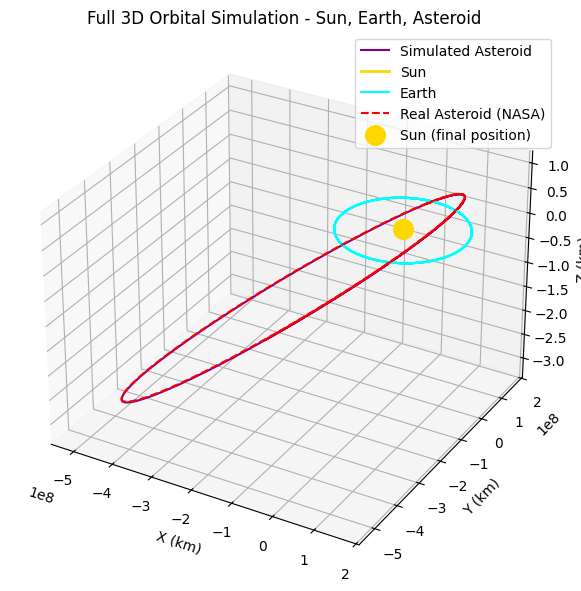

In [11]:
simulation_results = run_three_body_simulation(
    asteroid_position_ssb=asteroid_position_ssb,
    asteroid_velocity_ssb=asteroid_velocity_ssb,
    earth_position_ssb=earth_position_ssb,
    earth_velocity_ssb=earth_velocity_ssb,
    sun_position_ssb=sun_position_ssb,
    sun_velocity_ssb=sun_velocity_ssb,
    gravitational_constant=6.6790e-20
)

plot_simulation_results(simulation_results)